In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import emcee
import corner
import seaborn as sns
sns.color_palette("colorblind");

import eztao
from eztao.ts import mcmc, gpSimRand, gpSimFull, neg_param_ll, neg_fcoeff_ll, drw_fit, dho_fit, flat_prior
from eztao.carma import DRW_term, DHO_term, CARMA_term
from eztao.ts.carma_fit import sample_carma

from celerite import GP

%matplotlib inline

In [8]:
df = pd.read_csv('AGN_LightCurves/KIC9650712_agn_ztf_lc.csv')
df

,oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,...,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
0,766207400013324,44343332,2.458198e+06,58197.433322,16.522049,0.013410,0,zr,292.459966,46.373041,...,7,4,20.340000,25.930817,0.016646,0.066296,0.000007,30.0,1.828,2
1,766207400013324,46238960,2.458217e+06,58216.389607,16.542526,0.013481,0,zr,292.460033,46.372998,...,7,4,20.389999,26.080408,0.015100,0.093335,0.000006,30.0,1.740,2
2,766207400013324,46251717,2.458217e+06,58216.517176,16.517281,0.013394,0,zr,292.460062,46.373089,...,7,4,19.900000,26.202612,0.022051,0.101029,0.000012,30.0,1.100,2
3,766207400013324,46251813,2.458217e+06,58216.518137,16.512730,0.013378,0,zr,292.460039,46.373103,...,7,4,19.740000,26.214054,0.020952,0.098212,0.000011,30.0,1.098,1
4,766207400013324,46548601,2.458220e+06,58219.486018,16.508245,0.013363,0,zr,292.460030,46.373037,...,7,4,20.250000,26.077978,0.015835,0.094344,0.000006,30.0,1.153,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,766207400013324,162242351,2.459377e+06,59376.423518,16.717575,0.014145,0,zr,292.460025,46.372996,...,7,4,21.530001,26.330236,0.013577,0.082861,0.000005,30.0,1.034,1
1077,766207400013324,162438490,2.459379e+06,59378.384907,16.724125,0.014172,0,zr,292.459997,46.372976,...,7,4,21.490000,26.332813,0.013712,0.085508,0.000005,30.0,1.041,1
1078,766207400013324,162836780,2.459383e+06,59382.367801,16.725426,0.014177,0,zr,292.460021,46.372982,...,7,4,21.230000,26.180778,0.011893,0.089000,0.000004,30.0,1.045,1
1079,766207400013324,163240331,2.459387e+06,59386.403310,16.703770,0.014089,0,zr,292.460013,46.372999,...,7,4,21.100000,26.307564,0.011291,0.082001,0.000003,30.0,1.036,1


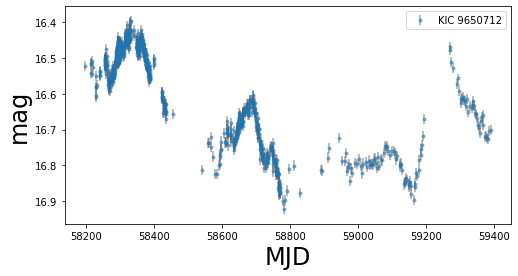

In [9]:
plt.figure(figsize=[8,4])
plt.errorbar(df['mjd'], df['mag'], yerr=df['magerr'], 
             linestyle='None', marker='.', alpha=0.5, ecolor='0.3', label='KIC 9650712')
plt.gca().invert_yaxis()
plt.xlabel('MJD', fontsize=24)
plt.ylabel('mag', fontsize=24)
plt.legend()
plt.savefig('KIC9650712_light_curve.png')
plt.show()

### For a DHO fit

In [10]:
t = df['mjd'].values
y_real = df['mag'].values
yerr_real = df['magerr'].values

# invert the magnitudes
y_real = (min(y_real)-y_real)

# normalize to unit standard deviation and zero mean
err = yerr_real/np.std(y_real)
y = (y_real - np.mean(y_real))/np.std(y_real)

In [12]:
# obtain best-fit
bounds = [(-15, 15), (-15, 15), (-20, 10), (-20, 10)]
best_dho = dho_fit(t, y, err, user_bounds=bounds)
print(f'Best-fit DHO: {best_dho}')
print(np.log(best_dho))

# define celerite GP model
dho_gp = GP(DHO_term(*np.log(best_dho)), mean=np.median(y))
dho_gp.compute(t, err)

Best-fit DHO: [0.13856475 0.00034814 0.01637389 0.03905357]
[-1.97641754 -7.9629061  -4.11206719 -3.24282094]


0
0
0


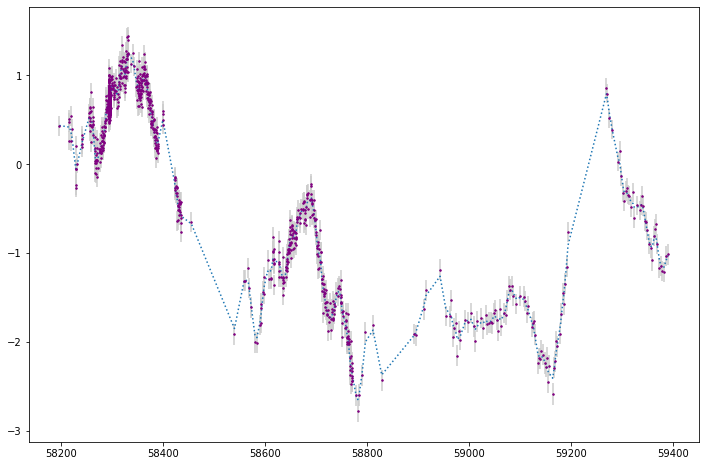

In [13]:
sim_t, sim_y, sim_yerr = eztao.ts.carma_sim.pred_lc(t, y, err, best_dho, 2, t)
print(np.sum(np.isnan(sim_t)))
print(np.sum(np.isnan(sim_y)))
print(np.sum(np.isnan(sim_yerr)))

plt.figure(figsize=[12,8])
plt.errorbar(t, y, yerr=err,
             linestyle="None", marker='.', ms=3., color='purple', ecolor='0.8')
plt.plot(sim_t, sim_y, linestyle=":") #, marker='o', alpha=0.5)
plt.show()

#### Define the prior and log-probability functions for MCMC

In [14]:
# Create the GP model -- instead of creating a "model" function that is then called by the "lnlike" function from tutorial,
#  we will create a GP that will be passed as an argument to the MCMC sampler. This will be the "gp" that is passed to
#  the "lnprob" and "param_ll" functions
kernel = DHO_term(*np.log(best_dho))
gp = GP(kernel, mean=np.median(y))
gp.compute(t, err)


# prior function for tau_perturb
def lnprior_perturb(theta):
    """Prior on perturbation timescale. Note: this is a wedge like prior."""
    
    # determine DHO timescales
    log10_tau_perturb = (theta[-1] - theta[-2])/np.log(10)
    if -3 <= log10_tau_perturb <= 5:
        prior = 0
    else:
        prior = -(np.abs(log10_tau_perturb - 1) - 4)
        
    return prior

def lnprior_bounds(theta):
    """Prior on AR and MA parameters. This is a flat prior."""
    
    # Place some bounds on the parameter space
    bounds_low = np.array([-15, -15, -20, -20])
    bounds_high = np.array([15, 15, 10, 10])

    log_a1, log_a2, log_b0, log_b1 = theta
    if ( 
        bounds_low[0] < log_a1 < bounds_high[0] 
        and bounds_low[1] < log_a2 < bounds_high[1] 
        and bounds_low[2] < log_b0 < bounds_high[2] 
        and bounds_low[3] < log_b1 < bounds_high[3] 
       ):
        return 0.0
    return -np.inf

# We'll use the eztao version which effectively returns "gp.log_likelihood" from the GP and np.inf otherwise
def lnlike(theta, y, gp):
    return -neg_param_ll(theta, y, gp)

def lnprob(theta, y, gp):
    lp_bounds = lnprior_bounds(theta)
    lp_perturb = lnprior_perturb(theta)                              
    if not np.isfinite(lp_bounds):
        return -np.inf
    return lp_bounds + lp_perturb + lnlike(theta, y, gp)






#### Initialize the data/starting place for MCMC

In [15]:
data = (t, y, err)
nwalkers = 128
niter = 2048

initial = np.array(np.log(best_dho))
print('initial guess:', initial)
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

initial guess: [-1.97641754 -7.9629061  -4.11206719 -3.24282094]


In [16]:
# Create the MCMC sampler -- note that the GP is passed as an argument in addition to the data
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[y, gp])

# run a burn-in surrounding the best-fit parameters obtained above
print("Running burn-in...")
p0, lp, _ = sampler.run_mcmc(p0, 200)
sampler.reset()

# clear up the stored chain from burn-in, rerun the MCMC
print("Running production...")
pos, prob, state = sampler.run_mcmc(p0, niter);

Running burn-in...
Running production...


In [19]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        sim_t, sim_y, sim_yerr = eztao.ts.carma_sim.pred_lc(t, y, err, 
                                                    np.exp(i), 2, t)
        models.append(sim_y)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread



# put all the samples that explored in MCMC into a single array
samples = sampler.flatchain
# find the parameters that have the best fit 
theta_max  = samples[np.argmax(sampler.flatlnprobability)]

med_model, spread = sample_walkers(100,samples)

Theta max:  [-1.98473974 -7.93199695 -4.1104516  -3.24126955]
exp Theta max:  [0.13741637 0.00035907 0.01640037 0.03911421]


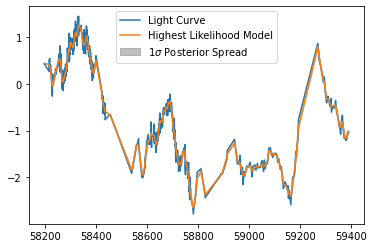

In [20]:
# put all the samples that explored in MCMC into a single array
samples = sampler.flatchain
# find the parameters that have the best fit 
theta_max  = samples[np.argmax(sampler.flatlnprobability)]

# print the best parameters
print('Theta max: ', theta_max) # these are in log-space
print('exp Theta max: ', np.exp(theta_max)) # take the exponent to get into 'normal' space 

# Let's plot the best fit parameters against our data
sim_t, sim_y, sim_yerr = eztao.ts.carma_sim.pred_lc(t, y, err, 
                                                    np.exp(theta_max), 2, t)
plt.plot(t, y, label='Light Curve')
plt.plot(t, sim_y, label='Highest Likelihood Model')
plt.fill_between(t, med_model-spread, med_model+spread,
                 color='grey', alpha=0.5, label=r'$1\sigma$ Posterior Spread')
plt.legend()
plt.show()


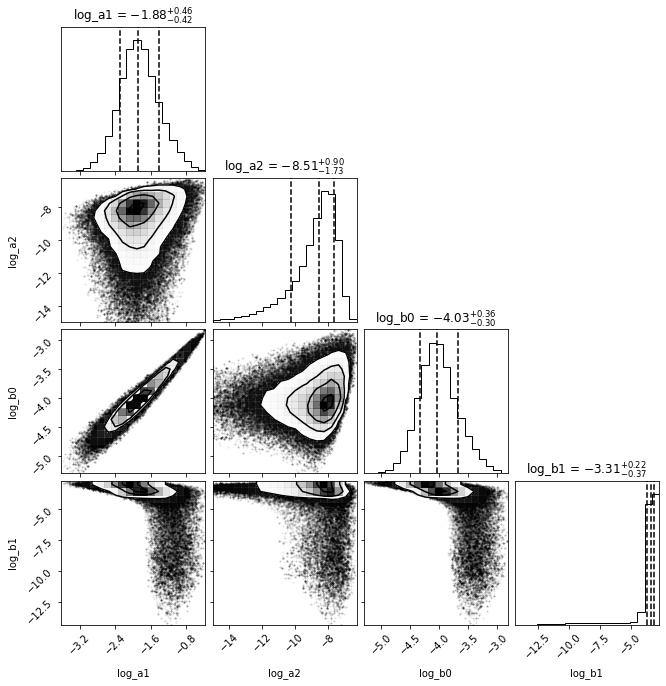

In [21]:
# Plot all the samples/parameters that were tried

# put all the samples that explored in MCMC into a single array
carma_flatchain = sampler.flatchain
theta_max  = samples[np.argmax(sampler.flatlnprobability)]

# remove points with low prob for the sake of making good corner plot
prob_threshold = np.percentile(sampler.flatlnprobability, 5)
clean_chain = carma_flatchain[sampler.flatlnprobability > prob_threshold, :]

# make corner plot
labels = [name for name in dho_gp.kernel.get_parameter_names()]
corner.corner(clean_chain, 
              quantiles=[0.16, 0.5, 0.84], labels=labels, show_titles=True,
              title_kwargs={"fontsize": 12});